In cell_seg_pipeline.ipynb, there were low cell counts. We can take advantage of the fact that spheroids are symmetric to fix this.

In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
from library import plots
import math
from scipy import interpolate
from cellpose import plot, utils
import os
from scipy.spatial import ConvexHull
percent_of_side = 0.10

## Read in Data

Note: The two channel images seem to have an offset. This messed up the analysis. I had to manually adjust the offset in the preprocessing step.

In [2]:
_, blue = cv2.imreadmulti('data/Blue-34a-dbl_0002.tiff', [], cv2.IMREAD_UNCHANGED)
_, red = cv2.imreadmulti('data/Red-34a-dbl_0002.tiff', [], cv2.IMREAD_UNCHANGED)
_, composite = cv2.imreadmulti('data/Composite-34a-dbl_0002.tiff', [], cv2.IMREAD_GRAYSCALE)

rows,cols = red[42].shape
M = np.float32([[1,0,10],[0,1,-3]])

# List of tuples of the form (blue, red) 
red_offset = [cv2.warpAffine(red[i],M,(cols,rows)) for i in range(len(red))]
blue_composite = [(blue[i], composite[i]) for i in range(len(composite))]

## Create segmentations of blue and red

In [60]:
# RUN CELLPOSE
import os
from cellpose import models, io
from cellpose import plot

# DEFINE CELLPOSE MODEL
model = models.CellposeModel(gpu=False, model_type='CPx')
folders = ['red','blue']
for folder in folders:
    if not os.path.exists(folder):
        os.mkdir(folder)

chan = [0,0]
for idx,img_red in enumerate(red_offset):
    if idx >= len(red)*percent_of_side and idx <= len(red)*(1-percent_of_side):
        masks, flows, diams = model.eval(img_red, diameter=45.6,flow_threshold=0.4, channels=chan)
        io.masks_flows_to_seg(img_red, masks, flows, 45.6, f'red/{idx}', chan)

chan = [0,0]
for idx,img_blue in enumerate(blue):
    if idx >= len(red)*percent_of_side and idx <= len(red)*(1-percent_of_side):
        masks, flows, diams = model.eval(img_blue, diameter=45.6,flow_threshold=0.4, channels=chan)
        io.masks_flows_to_seg(img_blue, masks, flows, 45.6, f'blue/{idx}', chan)

## Use segmentations to create plots

#### Find limits of data


In [3]:
from library import plots
max_limit = plots.max_limit(red)
print(max_limit)

3775.27693856999


#### Check number of cells in each frame 
The data doesn't include the entire spheroid. Some of the top of the spheroid wasn't captured.
To take advantage of the symmetry seen in the plot below we need to find the matching frame number on the bottom of the spheroid which seems to be 91.

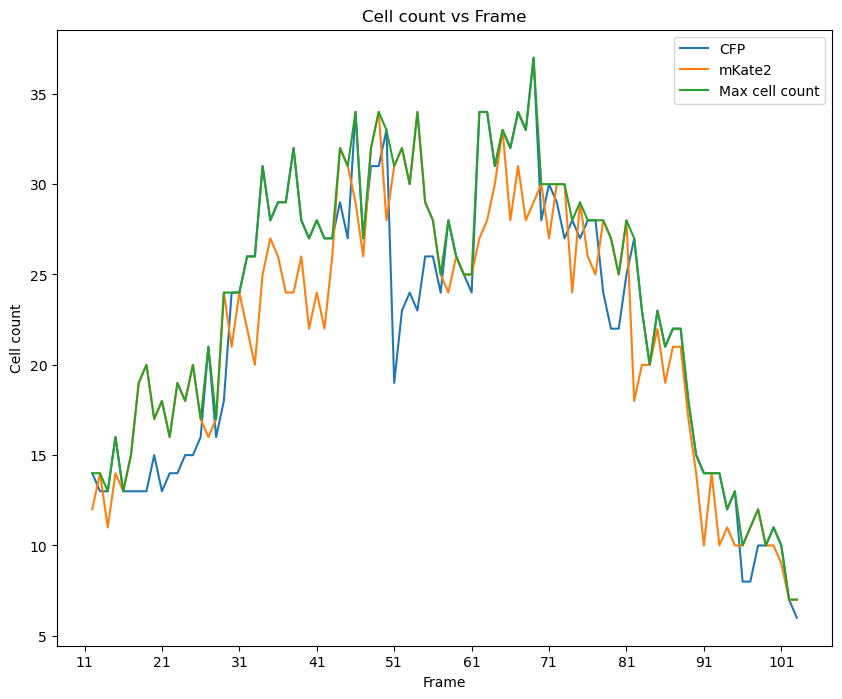

In [4]:
# Check number of cells in each frame using the segmentation masks
frames = []
for i in range(len(red)):
        if i >= len(red)*percent_of_side and i <= len(red)*(1-percent_of_side):
            frames.append(i)
cell_counts = []
for i in range(len(red)):
        if i >= len(red)*percent_of_side and i <= len(red)*(1-percent_of_side):
            cell_counts.append(plots.cell_count(i))

cell_counts = np.array(cell_counts)
# Plot cell count
plt.figure(figsize=(10,8))
plt.plot(frames,cell_counts[:,0], label='CFP')
plt.plot(frames,cell_counts[:,1], label='mKate2')
plt.plot(frames,np.max(cell_counts, axis=1), label='Max cell count')
plt.xticks(np.arange(int(len(red)*percent_of_side), int(len(red)*(1-percent_of_side)), step=10))
plt.xlabel('Frame')
plt.ylabel('Cell count')
plt.title('Cell count vs Frame')
plt.legend()

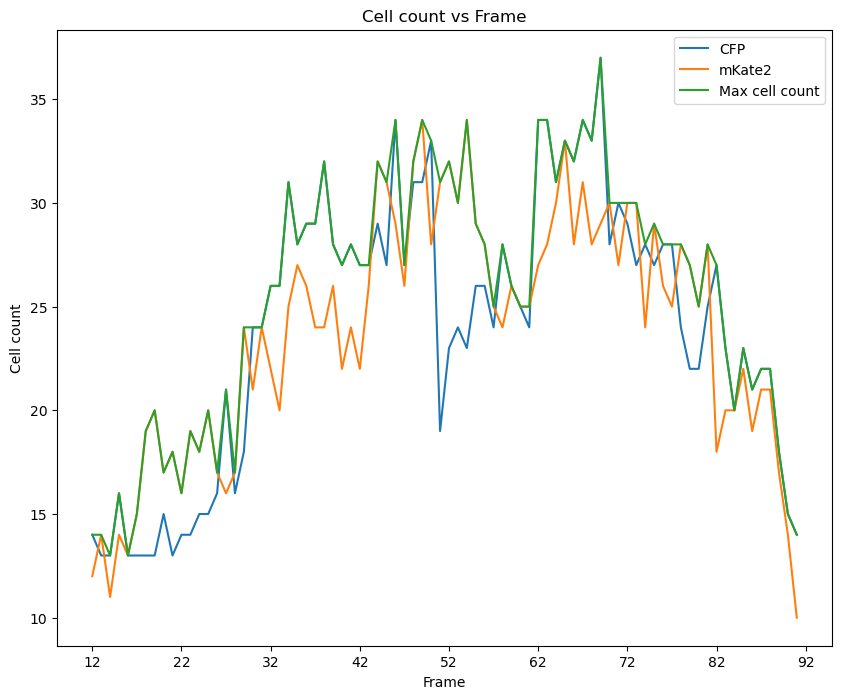

In [5]:
# Change data to only include frames 12-91
# List of tuples of the form (blue, red) 
red_offset = [cv2.warpAffine(red[i],M,(cols,rows)) for i in range(12,92)]
blue_composite = [(blue[i], composite[i]) for i in range(12,92)]

# Check number of cells in each frame using the segmentation masks
frames = []
for i in range(12,92):
    frames.append(i)
cell_counts = []
for i in range(12,92):
    cell_counts.append(plots.cell_count(i))

cell_counts = np.array(cell_counts)
# Plot cell count
plt.figure(figsize=(10,8))
plt.plot(frames,cell_counts[:,0], label='CFP')
plt.plot(frames,cell_counts[:,1], label='mKate2')
plt.plot(frames,np.max(cell_counts, axis=1), label='Max cell count')
plt.xticks(np.arange(12, 100, step=10))
plt.xlabel('Frame')
plt.ylabel('Cell count')
plt.title('Cell count vs Frame')
plt.legend()

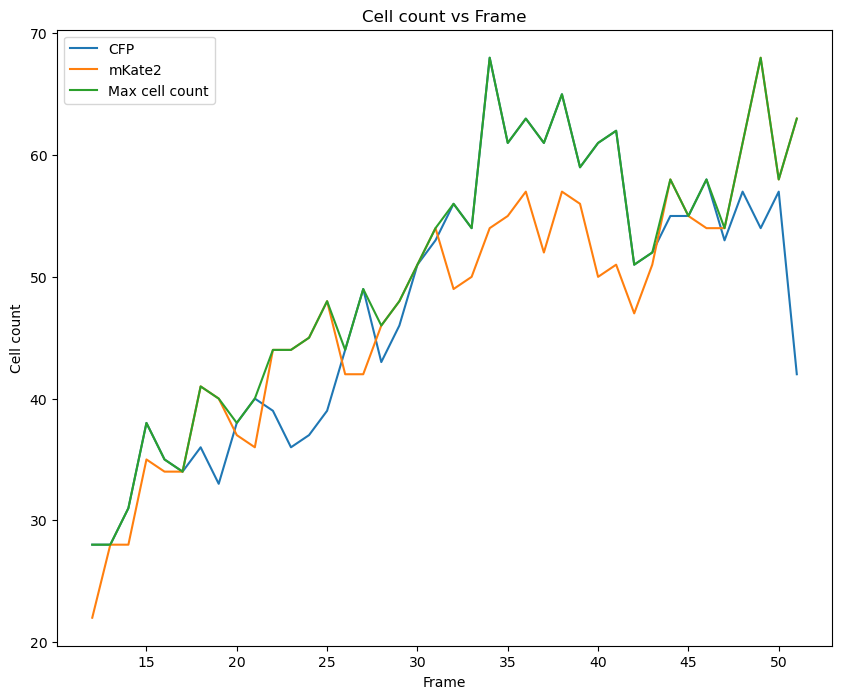

In [6]:
# Change data to only include frames 12-91
# Check number of cells in each frame using the segmentation masks
filenames = np.array([(12+i, 91-i) for i in range(len(red_offset)//2)])
cell_counts = []
for file in filenames:
    cell_counts.append(plots.cell_count(file[0])+plots.cell_count(file[1]))

cell_counts = np.array(cell_counts)
# Plot cell count
plt.figure(figsize=(10,8))
plt.plot(filenames[:,0],cell_counts[:,0], label='CFP')
plt.plot(filenames[:,0],cell_counts[:,1], label='mKate2')
plt.plot(filenames[:,0],np.max(cell_counts, axis=1), label='Max cell count')
plt.xlabel('Frame')
plt.ylabel('Cell count')
plt.title('Cell count vs Frame')
plt.legend()

In [7]:
# Use symmetry to augment data
red_offset_sym = [(red_offset[i], red_offset[-i]) for i in range(12, 12 + len(red_offset)//2)]
blue_composite_sym = [(blue_composite[i], blue_composite[-i]) for i in range(12, 12 + len(blue_composite)//2)]

In [8]:
name_of_file = 'plots/cell_scatter_aug_wimg.gif'
plotting_function = plots.blue_red_cell_scatter
filenames = filenames
intrinsics = []
extrinsics = []
totals = []
cv_red = []
cv_blue = []
data = {}
data['intrinsics'] = intrinsics
data['extrinsics'] = extrinsics
data['totals'] = totals 
data["cv_red"] = cv_red
data["cv_blue"] = cv_blue
data["lim"] = max_limit
data["augment"] = True
plots.create_gif_filenames(name_of_file, plotting_function, filenames, data)

Text(0.5, 1.0, 'Intrinsic Noise vs Frame')

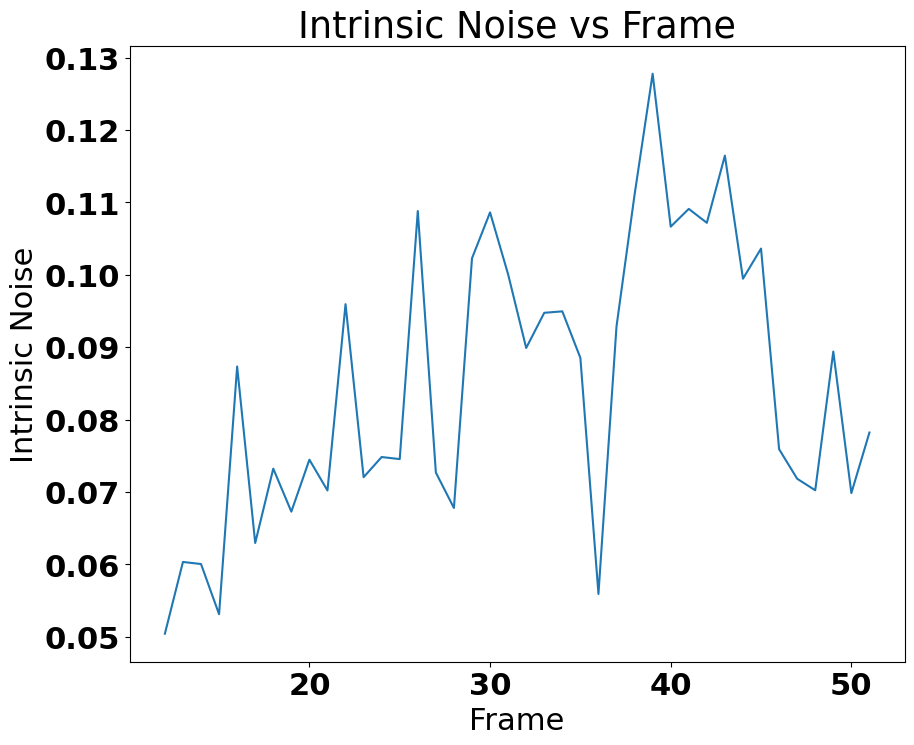

In [9]:
filenames= np.array(filenames)
# Plot intrinsic noise
plt.figure(figsize=(10,8))
plt.plot(filenames[:,0],data['intrinsics'])
plt.xlabel('Frame')
plt.ylabel('Intrinsic Noise')
plt.title('Intrinsic Noise vs Frame')

Text(0.5, 1.0, 'Extrinsic Noise vs Frame')

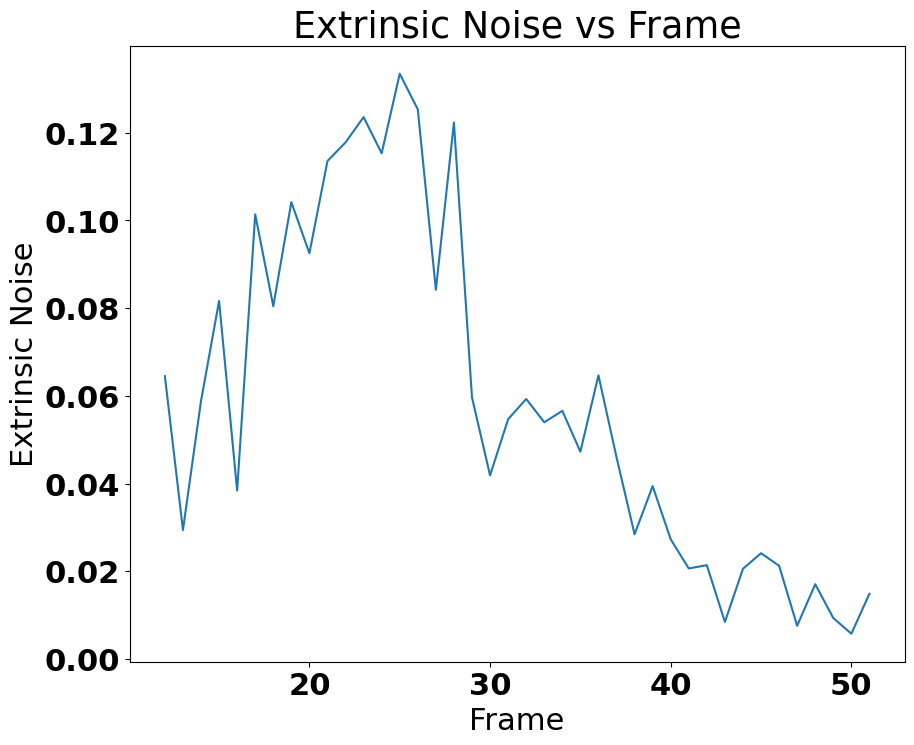

In [10]:
# Plot extrinsic noise
plt.figure(figsize=(10,8))
plt.plot(filenames[:,0],data['extrinsics'])
plt.xlabel('Frame')
plt.ylabel('Extrinsic Noise')
plt.title('Extrinsic Noise vs Frame')

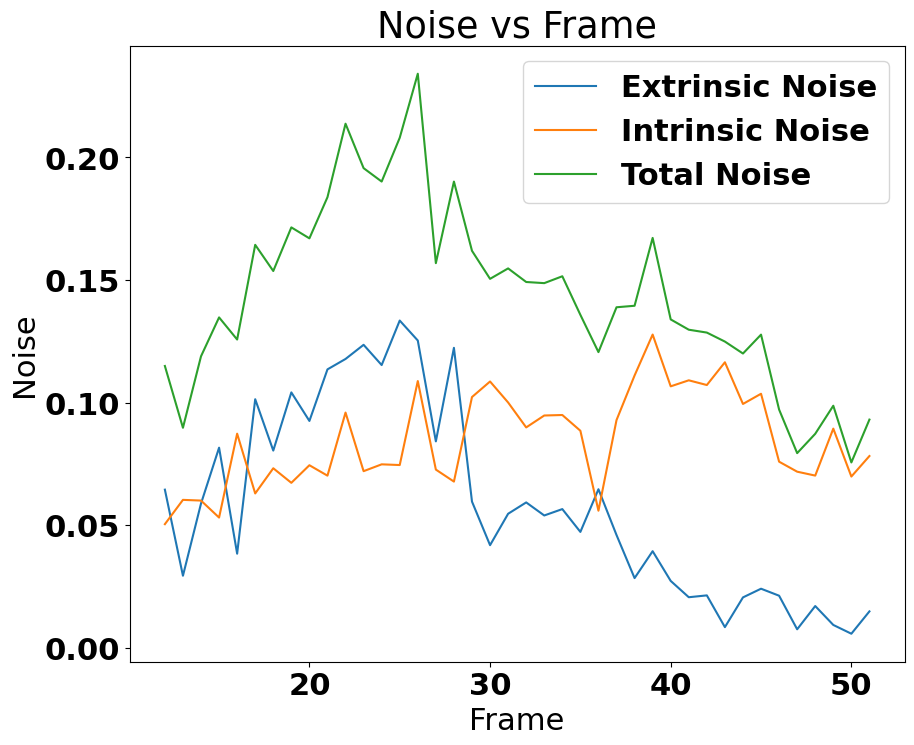

In [11]:
# Plot total noise
plt.figure(figsize=(10,8))
plt.plot(filenames[:,0],data['extrinsics'], label='Extrinsic Noise')
plt.plot(filenames[:,0],data['intrinsics'], label='Intrinsic Noise')
plt.plot(filenames[:,0],np.array(data['totals']), label='Total Noise')
plt.xlabel('Frame')
plt.ylabel('Noise')
plt.title('Noise vs Frame')
plt.legend()